#### 1. Setting the environment

In [1]:
"""
The following is an import of PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import numpy as np
#import nibabel as ni
import os, shutil
import time
import random
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
import os
import cv2
from scipy import ndimage
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from src.model.gm_vqvae import VQVAE, Encoder, ResBlock, Quantize, Decoder
from src.utils.dicom_utils import dcm2npy, RTStruct
from src.utils.dataloader import standard_resize2d, postprocess_mask
from scipy.ndimage import gaussian_filter
import argparse

#### 2. Defining the Exporting Functions

In [2]:
def extract_data_list(input_path, subject_id, vae_model, s_list, t_list):
  dicom_dir = os.path.join(input_path, str(subject_id))
  print(dicom_dir)
  ct, slices, contours, labels, dummy_mask = dcm2npy(dicom_dir)
  prostate = nib.load(os.path.join(input_path, str(subject_id) +  "/seg/Prostate", str(subject_id) + ".nii.gz")).get_fdata().transpose((2, 1, 0))
  rectum = nib.load(os.path.join(input_path, str(subject_id) + "/seg/Rectum", str(subject_id) + ".nii.gz")).get_fdata().transpose((2, 1, 0))
  bladder = nib.load(os.path.join(input_path, str(subject_id) + "/seg/Bladder", str(subject_id) + ".nii.gz")).get_fdata().transpose((2, 1, 0))

  prostate = np.flip(prostate, axis=(0, 1))
  rectum = np.flip(rectum,  axis=(0, 1))
  bladder = np.flip(bladder,  axis=(0, 1))

  prostate_list = [prostate]
  rectum_list = [rectum]
  bladder_list = [bladder]

  for s in s_list:
    for t in t_list:
      print(f"s: {s}, t: {t}")
      print(ct.shape)
      pred_mask_rectum, pred_mask_prostate, pred_mask_bladder = pred_contour(ct, prostate, rectum, bladder, vae_model, s, t)
      prostate_list.append(pred_mask_prostate)
      rectum_list.append(pred_mask_rectum)
      bladder_list.append(pred_mask_bladder)

  return slices, prostate_list, rectum_list, bladder_list

def pred_roi(gt, vae_model, s, t):
    gt = np.where(gt >= 0.2, gt, 0.0)
    pred = np.zeros(gt.shape)
    with torch.no_grad():
      for i in range(gt.shape[0]):
        if np.sum(gt[i, ...]) > 0:
          slice = gt.copy()[i, ...]
          crop, imin, imax, jmin, jmax = crop_around_centroid(slice, dim1=200)
          x = load_data_images(crop)
          y, latent_loss = vae_model(x.to(device), s)
          y = y.detach().cpu().numpy()
          dim = crop.shape
          y = standard_resize2d(y[0, 0, ...], dim)
          if y.sum() < 200*200:
            pred[i, imin:imax, jmin:jmax] = postprocess_mask(y.copy(), s)
          else:
            pred[i, imin:imax, jmin:jmax] = pred[i-1, imin:imax, jmin:jmax]

    result = pred.copy()
    return result

def pred_contour(ct, prostate, rectum, bladder, vae_model, s, t):
  # Predict & postprocess
  vae_model = [model.eval() for model in vae_model]
  pred_rectum = pred_roi(rectum, vae_model[1], s, t)
  pred_rectum = (pred_rectum >  t).astype("bool")
  pred_prostate = pred_roi(prostate, vae_model[0], s, t)
  pred_prostate = (pred_prostate >  t).astype("bool")
  pred_bladder = pred_roi(bladder, vae_model[2], s, t)
  pred_bladder = (pred_bladder >  t).astype("bool")

  return pred_rectum, pred_prostate, pred_bladder 
  
def crop_around_centroid(array, dim1):
  i, j = ndimage.center_of_mass(array)
  i, j = int(i), int(j)
  w = int(dim1/2)
  imin = max(0,i-w)
  imax = min(array.shape[0],i+w+1)
  jmin = max(0,j-w)
  jmax = min(array.shape[1],j+w+1)
  crop =  array[imin:imax,jmin:jmax]

  return crop, imin, imax, jmin, jmax

def load_data_images(image):
  image = np.pad(image, ((1,0), (1,0)), "constant", constant_values=0)
  dim = (256,256)
  image = torch.Tensor(standard_resize2d(image, dim))
  image = torch.reshape(image, (1,1, 256, 256))
  image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
  return image

def export_data(input_path, subject_id, vae_model, outpath, s_list, t_list):
  n = len(s_list) * len(t_list)
  ct_slices, prostate_list, rectum_list, bladder_list = extract_data_list(input_path, subject_id, vae_model, s_list, t_list)

  prostate_name = ["original_prostate"]
  prostate_color = ["red"]
  for i in range(1, n+1):
    prostate_name.append("uncertainty_prostate_" + str(i))
    prostate_color.append("green")

  rectum_name = ["original_rectum"]
  rectum_color = ["red"]
  for i in range(1, n+1):
    rectum_name.append("uncertainty_rectum_" + str(i))
    rectum_color.append("green")

  bladder_name = ["original_bladder"]
  bladder_color = ["red"]
  for i in range(1, n+1):
    bladder_name.append("uncertainty_bladder_" + str(i))
    bladder_color.append("green")
  
  RTStruct(prostate_list + rectum_list + bladder_list, prostate_name + rectum_name + bladder_name, color=prostate_color + rectum_color + bladder_color, DICOMImageStruct = ct_slices, fname=os.path.join(outpath, str(subject_id) + "/rtstruct/rtss.dcm"))


#### 3. Setting arguments for the the exportation

In [3]:
input_path = "input"
subject_id =  "subject1"
output_path = "output"
checkpoint_prostate = "checkpoints/gmvqvae/best/model_gmvqvae_best_prostate.pt"
checkpoint_rectum = "checkpoints/gmvqvae/best/model_gmvqvae_best_rectum.pt"
checkpoint_bladder = "checkpoints/gmvqvae/best/model_gmvqvae_best_bladder.pt"
s_list = [5, 15]
t_list = [0.3]

In [4]:
def copy_folder(input_path, folder_name, output_path):
    try:  
        # Combine input path and folder name to get the full path
        source_folder = os.path.join(input_path, folder_name)

        # Check if the source folder exists
        if os.path.exists(source_folder) and os.path.isdir(source_folder):
            # Combine output path and folder name to get the full path for the copy
            destination_folder = os.path.join(output_path, folder_name)

            # Use shutil.copytree to copy the entire folder
            shutil.copytree(source_folder, destination_folder)

            print(f"Folder '{folder_name}' copied successfully to '{output_path}'")
        else:
            print(f"Folder '{folder_name}' does not exist in '{input_path}'")
    except:
        print("folder already existed!")
        pass
input_path_ct = "input"
subject_id =  "subject1"
output_path = "output"

copy_folder(input_path + "/ct", subject_id, output_path)

Folder 'subject1' does not exist in 'input/ct'


#### 5. Exportation to the Output Folder

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gmvqvae_model_prostate = torch.load(checkpoint_prostate, map_location=torch.device('cpu'))
gmvqvae_model_prostate.to(device)
gmvqvae_model_rectum = torch.load(checkpoint_rectum, map_location=torch.device('cpu'))
gmvqvae_model_rectum.to(device)
gmvqvae_model_bladder = torch.load(checkpoint_bladder, map_location=torch.device('cpu'))
gmvqvae_model_bladder.to(device)
gmvqvae_model = [gmvqvae_model_prostate, gmvqvae_model_rectum, gmvqvae_model_bladder]
export_data(input_path, subject_id, gmvqvae_model, output_path, s_list, t_list)

input\subject1


   Missing contours for structure: CTV
   Missing contours for structure: sigmoid
   Missing contours for structure: ROI_1
   Missing contours for structure: sigmoid Avoid JK
s: 5, t: 0.3
(187, 512, 512)
s: 15, t: 0.3
(187, 512, 512)


c:\Users\lykha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydicom\dataset.py:2231: UserWarning: Camel case attribute 'ColorType' used which is not in the element keyword data dictionary
  warnings.warn(msg)
c:\Users\lykha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydicom\dataset.py:2231: UserWarning: Camel case attribute 'SoftwareVersion' used which is not in the element keyword data dictionary
  warnings.warn(msg)
c:\Users\lykha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydicom\dataset.py:2231: UserWarning: Camel case attribute 'Width' used which is not in the element keyword data dictionary
  warnings.warn(msg)
c:\Users\lykha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydicom\dataset.py:2231: UserWarning: Camel case attribute 'Height' used which is not in the element keyword data dictionary
  warnings.warn(msg)
c:\Users\lykha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydicom\dataset.py:2231: UserWarning: Ca

#### 6. Visualization of the Uncertainty Contours

In [48]:
def plot_contour(ct, gt,  mask, i):
  plt.imshow(ct[i, 150:450, 150:450], cmap="Greys_r", vmin=-250, vmax=250)

  # GT
  
  gt_r = np.where(gt[0] > 0.1, 1.0, 0.0)
  gt_p = np.where(gt[1] > 0.1, 1.0, 0.0)
  gt_b = np.where(gt[2] > 0.1, 1.0, 0.0)
  
  plt.contour(gt_r[i, 150:450, 150:450], cmap="Greens")
  plt.contour(gt_p[i, 150:450, 150:450], cmap="Greens")
  plt.contour(gt_b[i, 150:450, 150:450], cmap="Greens")

  # Mask 1
  mask_t_r = np.where(mask[0] > 0, 1.0, 0.0)
  mask_t_p = np.where(mask[1] > 0, 1.0, 0.0)
  mask_t_b = np.where(mask[2] > 0, 1.0, 0.0) 
  
  plt.contour(mask_t_r[i, 150:400, 150:400], cmap = "Reds")
  plt.contour(mask_t_p[i, 150:400, 150:400], cmap = "Reds")
  plt.contour(mask_t_b[i, 150:400, 150:400], cmap = "Reds")
  
  plt.show()

In [30]:
#gt = [prostate, rectum, bladder]

ct, slices, contours, labels, dummy_mask = dcm2npy(os.path.join(output_path, str(subject_id)))

In [31]:
labels.shape

(187, 512, 512, 9)

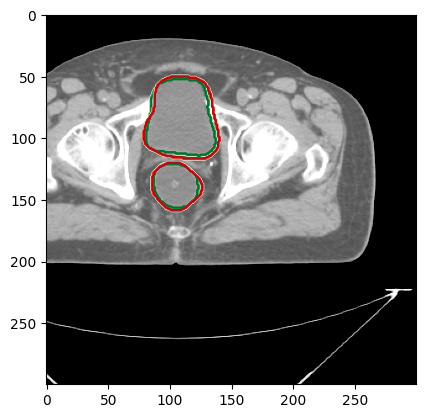

In [50]:
i = 65
gt = [labels[..., 0], labels[..., 3], labels[..., 6]]
mask1 = [labels[..., 1], labels[..., 4], labels[..., 7]]

plot_contour(ct, gt, mask1, i)

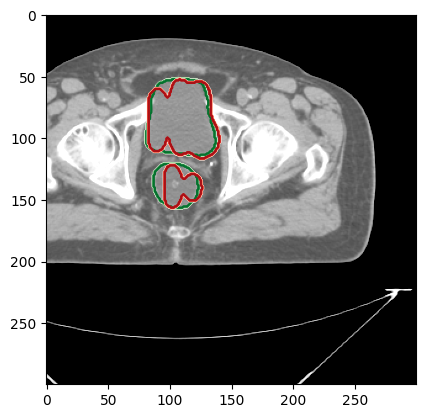

In [51]:
i = 65
gt = [labels[..., 0], labels[..., 3], labels[..., 6]]
mask2 = [labels[..., 2], labels[..., 5], labels[..., 8]]

plot_contour(ct, gt, mask2, i)